In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cvutils
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from scipy.misc import imread, toimage

%matplotlib inline

In [4]:
root_path = 'samples//'
samples_path = root_path + "samples.png"

In [5]:
samples_core = cv2.imread(root_path+"cores.png", cv2.IMREAD_GRAYSCALE)
samples_delta = cv2.imread(root_path+"deltas.png", cv2.IMREAD_GRAYSCALE)
samples_neg = cv2.imread(root_path+"negs.png", cv2.IMREAD_GRAYSCALE)

np.random.seed(42)
np.random.shuffle(samples_core)
np.random.shuffle(samples_delta)
np.random.shuffle(samples_neg)

n_test = 500
samples_train = np.vstack((samples_core[:-n_test], samples_delta[:-n_test], samples_neg[:-n_test]))
samples_test = np.vstack((samples_core[-n_test:], samples_delta[-n_test:], samples_neg[-n_test:]))

n_cores, n_deltas, n_negs = samples_core.shape[0]-n_test, samples_delta.shape[0]-n_test, samples_neg.shape[0]-n_test

labels_train = np.concatenate( ( np.ones(n_cores), 2*np.ones(n_deltas), 3*np.ones(n_negs) ) ).astype(np.int)
labels_test = np.concatenate( ( np.ones(n_test), 2*np.ones(n_test), 3*np.ones(n_test) ) ).astype(np.int)

print(samples_train.shape, samples_test.shape, labels_train.shape, labels_test.shape)
print(np.bincount(labels_train), np.bincount(labels_test))

(4006, 1600) (1500, 1600) (4006,) (1500,)
[   0 1172 1480 1354] [  0 500 500 500]


In [6]:
def compute_hog_descriptors(samples):
    im_array = []
    for sample in samples:
        im = np.reshape(sample, (40,40))
        
        hog = cv2.HOGDescriptor((40,40), (16,16), (8,8), (8,8), 9)
        hog_desc = hog.compute(im)
        
        im_array.append(hog_desc.ravel())
        
    return np.asarray(im_array, dtype=np.float64).reshape(-1, hog_desc.shape[0])

In [7]:
batch_train = compute_hog_descriptors(samples_train)
batch_test = compute_hog_descriptors(samples_test)

print(batch_train.shape, batch_test.shape)

(4006, 576) (1500, 576)


In [6]:
estimators = [('StdScaler', StandardScaler()), ('SVC', SVC())]
pipe = Pipeline(estimators)
parameters = dict(SVC__kernel=['linear', 'rbf'], SVC__C=[1, 10])
clf = GridSearchCV(pipe, parameters, cv=10, verbose=10, n_jobs=-1)
clf.fit(batch_train, labels_train)
print(clf.best_params_, clf.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   18.3s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   22.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.8s finished


{'SVC__C': 10, 'SVC__kernel': 'rbf'} 0.996754867698


In [7]:
estimators = [('StdScaler', StandardScaler()), ('Kbest', SelectKBest()), ('SVC', SVC(kernel='rbf', C=10))]
pipe = Pipeline(estimators)
parameters = dict(Kbest__k=range(1, batch_train.shape[1], 50))
clf = GridSearchCV(pipe, parameters, cv=10, verbose=10, n_jobs=-1)
clf.fit(batch_train, labels_train)
print(clf.best_params_, clf.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   32.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   32.5s finished


{'Kbest__k': 401} 0.997503744383


In [8]:
estimators = [('StdScaler', StandardScaler()), ('Kbest', SelectKBest()), ('SVC', SVC(kernel='rbf', C=10))]
pipe = Pipeline(estimators)
parameters = dict(Kbest__k=range(350, 450, 10))
clf = GridSearchCV(pipe, parameters, cv=10, verbose=10, n_jobs=-1)
clf.fit(batch_train, labels_train)
print(clf.best_params_, clf.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   34.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.6s finished


{'Kbest__k': 380} 0.998002995507


In [9]:
labels_pred = clf.predict(batch_test)

print(accuracy_score(labels_test, labels_pred))
print(confusion_matrix(labels_test, labels_pred))

0.996
[[499   0   1]
 [  0 499   1]
 [  4   0 496]]


In [11]:
core_errors = samples_test[(labels_test == 1) & (labels_pred != 1)]
delta_errors = samples_test[(labels_test == 2) & (labels_pred != 2)]
neg_errors = samples_test[(labels_test == 3) & (labels_pred != 3)]

print(core_errors.shape, delta_errors.shape, neg_errors.shape)

(1, 1600) (1, 1600) (4, 1600)


In [12]:
def plot_errors(errors):
    plt.figure(figsize=(16,1))
    n_errors = errors.shape[0]
    i = 1
    for error in errors:
        plt.subplot(1, n_errors, i)
        plt.imshow(error.reshape(40,40), cmap='gray')
        i += 1

In [24]:
def save_errors(output_folder, str_prefix, errors):
    for error, i in zip(errors, range(errors.shape[0])):
        cv2.imwrite("{0}{1}_{2}.png".format(output_folder, str_prefix, i), error.reshape(40,40))

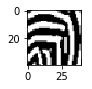

In [17]:
plot_errors(core_errors)

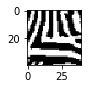

In [14]:
plot_errors(delta_errors)

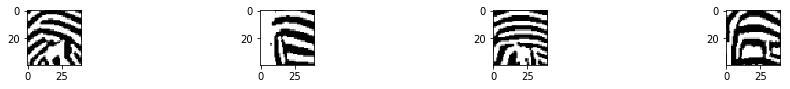

In [15]:
plot_errors(neg_errors)

In [25]:
save_errors(root_path+"errors\\", "core", core_errors)
save_errors(root_path+"errors\\", "delta", delta_errors)
save_errors(root_path+"errors\\", "neg", neg_errors)

In [10]:
scores = []
for i in range(10000):
    print("\r", i, end='')
    x_test, y_test = resample(batch_test, labels_test, replace=True, n_samples=150)
    y_pred = clf.predict(x_test)
    
    scores.append(accuracy_score(y_test, y_pred))

 999911401697274235364703496054665528877593409700

In [ ]:
best_pipe = clf.best_estimator_
kbest = best_pipe.steps[1][1]

In [ ]:
best_features = np.sort(np.argsort(kbest.scores_)[-kbest.k:])
print(best_features.shape, best_features, sep='\n')

In [16]:
np.savetxt('C:\\Users\\Pesquisa\\Documents\\Arnaldo\\Singularidades\\scores.txt', scores, fmt='%.5f', delimiter=',')

# PCA

In [8]:
from sklearn.decomposition import PCA

In [14]:
batch = np.vstack((batch_train, batch_test))
labels = np.hstack((labels_train, labels_test))
print(batch.shape, labels.shape)

(5506, 576) (5506,)


In [11]:
pca = PCA()
pca.fit(batch)

print(np.cumsum(pca.explained_variance_ratio_))

[ 0.15606211  0.29708027  0.42573108  0.54744694  0.66023494  0.70080536
  0.73671472  0.76150055  0.77803951  0.79434299  0.80762929  0.81712087
  0.8261386   0.83472439  0.8427124   0.84975681  0.85570685  0.86094963
  0.8657866   0.86955878  0.87328028  0.87680675  0.88012355  0.88324058
  0.88611415  0.88885611  0.89127039  0.89362784  0.8959543   0.89814386
  0.90018004  0.90211043  0.90395049  0.90576773  0.90744839  0.90906482
  0.9106631   0.91222668  0.91375344  0.91522859  0.91663461  0.91795254
  0.91926607  0.92044433  0.92158871  0.92271866  0.92381068  0.92487376
  0.92590646  0.92691944  0.92791767  0.92888066  0.92982492  0.93075917
  0.93167714  0.93257094  0.9334358   0.93429168  0.93511382  0.9359219
  0.93671354  0.93748478  0.93823829  0.93898515  0.93972021  0.94041851
  0.94110605  0.94179116  0.9424711   0.943122    0.94376402  0.94439528
  0.9450131   0.94562574  0.94622239  0.94681634  0.94739297  0.94796363
  0.94852505  0.94907479  0.94962061  0.95015226  0.

In [12]:
pca = PCA(n_components=2)
pca.fit(batch)
batch_pca = pca.transform(batch)

print(batch_pca.shape)

(5506, 2)


In [16]:
labels.min(), labels.max()

(1, 3)

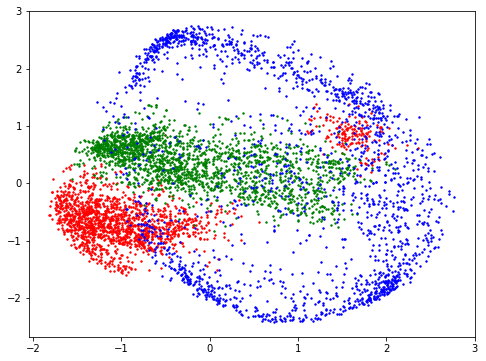

In [27]:
plt.figure(figsize=(8,6))

for l, c in zip(range(1,4), ["red", "green", "blue"]):
    batch_ = batch_pca[labels == l]
    plt.scatter(batch_[:, 0], batch_[:, 1], s=2, c=c)

In [20]:
res = np.hstack((batch_pca, labels.reshape(-1,1)))
print(res.shape)

(5506, 3)


In [22]:
np.savetxt('samples.csv', res, delimiter=',')